# Honey, I Shrunk the Data

Anthony Finch

--------------------

In *Is Bigger Really Better?*, we asked how we might go about commanding a squad of robots to find a needle in a warehouse full of hay if we couldn't actually tell the robots what to look for.  We considered three potentially helpful steps in this process, although none of these steps would completely solve our problem.

In this post, we'll explore the first helpful step that we could ask the robots to take: mapping out the warehouse to help us in our future search efforts.



# A Map that Leads to Needles

Let's consider a large, multi-dimensional dataset.  For now, this dataset is going to represent our hay.

To build this dataset, we're going to use some random number generators from `numpy`.  In fact, we're going to create three different sets of data.  The difference between these data sets is in how they're related to one another.  The features aren't all going to be independent.  In other words, the value for one feature is going to inform the value of another feature.  This is often true in real data.  It will also become very important later on.

In [15]:
import numpy as np
import pandas as pd

In [26]:
#Hot Tip: Don't know how to use the np.random package?
#Try using the command help(np.random) to see which distributions
#are available and use help(np.random.normal) to see what the API
#looks like!

#Set your desired number of data points.
N = 100000

#Dataset 1 - these features are completely independent
f1_1 = np.random.normal(0, 1, N)
f1_2 = np.random.uniform(0, 1, N)
f1_3 = np.random.exponential(1, N)
f1_4 = np.random.chisquare(1, N)

df_1 = pd.DataFrame({
    'f1' : f1_1,
    'f2' : f1_2,
    'f3' : f1_3,
    'f4' : f1_4
})


#Dataset 2 - these features are linearly correlated
hidden_feature_1 = np.random.normal(0,1,N)
hidden_feature_2 = np.random.normal(0,1,N)

f2_1 = np.random.normal(0,1,N) + hidden_feature_1 - hidden_feature_2
f2_2 = np.random.normal(0,1,N) - hidden_feature_1 + hidden_feature_2
f2_3 = np.random.normal(0,1,N) + hidden_feature_1 + hidden_feature_2 - 1
f2_4 = np.random.normal(0,1,N) - hidden_feature_1 - hidden_feature_2 + 1

df_2 = pd.DataFrame({
    'f1' : f2_1,
    'f2' : f2_2,
    'f3' : f2_3,
    'f4' : f2_4
})

#Dataset_3 - these features have complex nonlinear relationships
f3_1 = np.random.normal(0,1,N)
f3_2 = np.abs(f3_1) - np.random.exponential(1,N)
f3_3 = f3_1*np.random.chisquare(1,N)
f3_4 = f3_3/(1+np.abs(f3_2))

df_3 = pd.DataFrame({
    'f1' : f3_1,
    'f2' : f3_2,
    'f3' : f3_3,
    'f4' : f3_4
})

### Examining Our Handiwork

Now, let's take a quick look at what these distributions look like using Seaborn's `pairplot`s.

In [27]:
import seaborn as sns

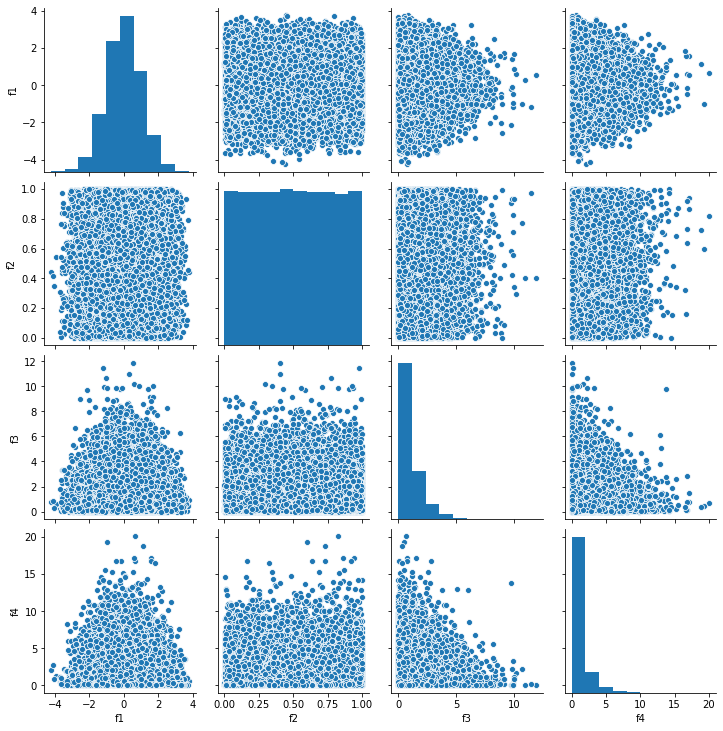

In [28]:
sns.pairplot(df_1)

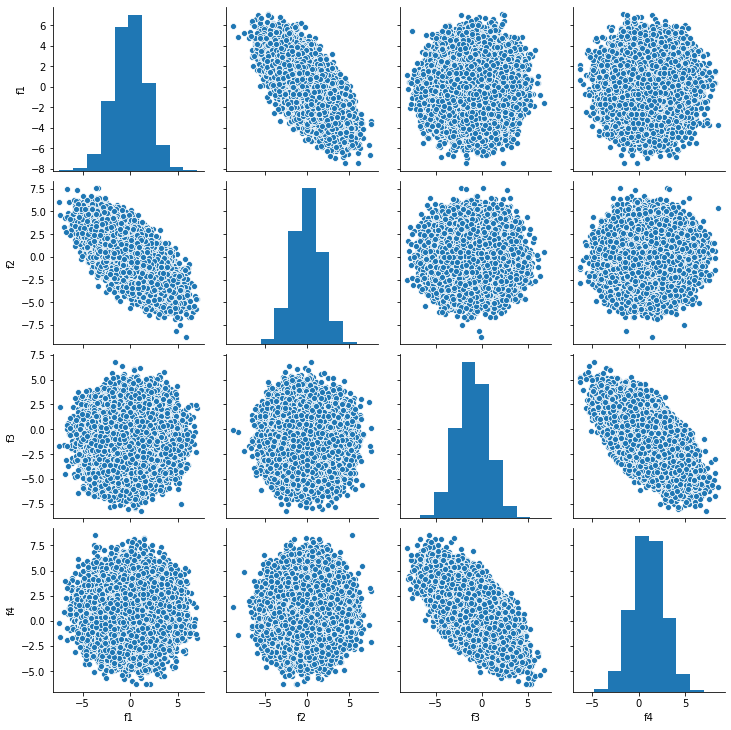

In [29]:
sns.pairplot(df_2)

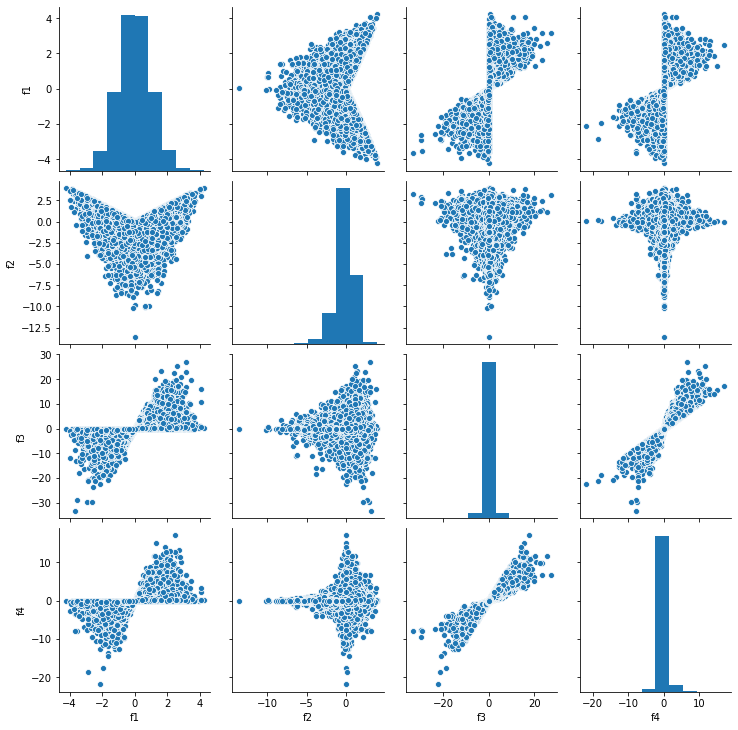

In [30]:
sns.pairplot(df_3)

### Mapmakers, Mapmakers, Make Me Some Maps

Right now, we're looking for some algorithms which will help us to take these 4-dimensional datasets and crush them down into something smaller and more manageable.  For now, let's say that we want to get down to just 2 dimensions.  Fittingly, this operation is called *dimensionality reduction* or *compression*.

There are many ways to achieve this, but let's remind ourselves of our requirements:

1. The data is an input - we put in all of the features.
2. The output is smaller (say, two dimensions).
3. We need a way to reconstruct our original features from the data.

We'll discuss three ways of doing this.

# Linear Dimensionality-Reduction

Let's harken back to our introductory Linear Algebra classes for a few moments.  If you didn't take Linear Algebra, that's okay, too!  This is pretty simple.

We can express our data as an $M$-dimensional dataset with $N$ points.  In our case, we have $N = 10000$ (our number of data points) and $M = 4$ (our number of features).  Fortunately for us, numpy can do this for us pretty easily.

We'll express this matrix as an $N x M$ matrix ($N$ rows, $M$ columns).

In [32]:
np.matrix(df_1)

matrix([[-1.05760905e-01,  7.33755757e-01,  3.99933609e-01,
          5.90740306e+00],
        [-7.74403476e-02,  8.06561862e-01,  5.88443211e-01,
          2.99471856e-01],
        [-2.03224942e+00,  2.36783844e-02,  6.36999730e-02,
          9.28984165e-01],
        ...,
        [-1.63197596e+00,  3.61354419e-01,  1.23967382e-01,
          1.65635467e-03],
        [-2.05498894e+00,  9.35564529e-01,  2.46757551e+00,
          2.40345681e+00],
        [-3.28007944e-01,  7.35619457e-01,  2.43294404e-01,
          6.72739739e-02]])

In [33]:
np.matrix(df_1).shape

(100000, 4)

If you did take linear algebra, you'll probably remember doing a lot of matrix multiplication.  Remember that, when we multiply matrices, we multiply the **rows** of the first matrix by the **columns** of the second matrix.

For example, let's say that we have the matrix $A$ and another matrix $B$.

In [34]:
A = np.matrix([[1,2], [3,4]])
A

matrix([[1, 2],
        [3, 4]])

In [36]:
B = np.matrix([[5,6],[7,8]])
B

matrix([[5, 6],
        [7, 8]])

If we want to multiply $A$ by $B$ (this is denoted $AB$), then we would multiply the first row of $A$ by the first column of $B$ to get the top-left value.  Then we'd multiply the first row of $A$ by the second column of $B$ to get the top right value, and so on.  It would look like this:

$$AB = \left[\begin{array}[cc]] 1*5 + 2*7 & 1*6 + 2*8 \\ 3*5 + 4*7 & 3*6 + 4*8\end{array}\right]$$

In [40]:
#WARNING: using the numpy.multiply() command gives the element-wise product, which isn't what we want!
np.matmul(A,B)

matrix([[19, 22],
        [43, 50]])

The interesting thing about matrix multiplication is that it doesn't require matrices of the same size.  Instead, the number of rows in the first matrix has to match the number of columns in the second matrix, and the number of rows in the second matrix has to match the number of columns in the first.  In other words, it's completely fine if we create a new matrix $C$ like the following.

In [42]:
C = np.matrix([[9],[10]])
C

matrix([[ 9],
        [10]])

In [43]:
np.matmul(A,C)

matrix([[29],
        [67]])

Wait - we just *reduced the dimensionality* of $A$!

Huzzah!  Let's go eat lunch.


# Optimizing the Dimensionality-Reduction

Let's summarize our observation - we can create a smaller dimensionality by building a matrix that has fewer columns than our current matrix.  That's it.  By the way, that's the same thing as saying that we can write an equation like this:

$$ \alpha_1*x_1 + \alpha_2*x_2 = \text{Something valuable}$$

That is, assuming we're trying to reduce to just a single dimension from two starting dimensions.

The point is, we can find coefficients (in this case, $\alpha_1$ and $\alpha_2$) which will give us fewer dimensions.  This satisfies two of our conditions:

1. The method takes our data as an input.
2. It produces a smaller matrix than we started out with.

Unfortunately, we still have one requirement left:

3. We need to be able to get back to our original matrix (or close to it)!